<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/exponential_smoothing_and_static_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exponential smoothing and static maps
In this exercise we will try to craft different flavours of exponential smoothing algorithms from scratch, and compare their performance. Recalling that the exponential smoothing forecasters have a state space form, we will also try to compare them with static maps, such as linear regression on the time series embedding. 



In [1]:
%%capture
!pip install wget
import pandas as pd
import wget
import numpy as np
data = pd.read_pickle(wget.download("https://zenodo.org/record/4549296/files/reduced_dataset.pk?download=1"));

In [2]:
samples_per_day = 24
data = pd.concat([data['all'], pd.Series(np.vstack(data['ghi_backwards'])[:, 0], name='ghi', index=data.index), pd.Series(np.vstack(data['temperature'])[:, 0], name='T', index=data.index)], axis=1)
data = data.resample('1h', origin='start').mean()
data /= data.std()
data.head()


all  ghi         T
2018-01-13 00:10:00+00:00  4.080396  0.0  0.438564
2018-01-13 01:10:00+00:00  3.786664  0.0  0.429876
2018-01-13 02:10:00+00:00  3.636162  0.0  0.419790
2018-01-13 03:10:00+00:00  3.762088  0.0  0.399790
2018-01-13 04:10:00+00:00  3.831009  0.0  0.351505

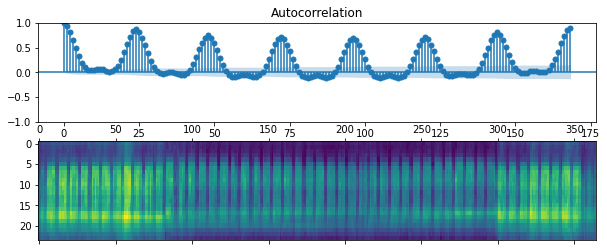

In [3]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2, 1, figsize=(10, 4))
_ = sm.graphics.tsa.plot_acf(data['all'], lags=24*7, ax=ax[0])

y = data['all'].loc[data.index<'2019-01-13']
y = pd.concat([y, pd.Series(y.index.dayofyear, name='day', index=y.index),
               pd.Series(y.index.hour, name='hour', index=y.index)], axis=1)
y_mat = y.pivot(index='day', columns='hour', values='all').T
ax[1].matshow(y_mat, aspect='auto')



In the following we just define an auxiliary function for showing some animations. It accepts a pd.DataFrame of ground truth values and a numpy matrix of predictions


In [4]:

from matplotlib import animation
from IPython.display import HTML

def ts_animation(y_te, y_hat, n_rows=50):
  "plot the first n_rows of the two y_te and y_hat matrices"
  fig, ax = plt.subplots(1);
  y_min = np.minimum(np.min(y_hat), np.min(y_te))
  y_max = np.maximum(np.max(y_hat), np.max(y_te))
  line1, = ax.plot(y_hat[0], lw=2);
  line2, = ax.plot(y_hat[0], lw=2);
  ax.set_ylim(y_min, y_max)
  n_sa = y_hat.shape[1]
  def animate(i):
    line1.set_data(np.arange(n_sa),y_te.values[i:i+n_sa]);
    line2.set_data(np.arange(n_sa),y_hat[i,:]);
    return (line1,line2) 

  def init():
    line1.set_data([], []);
    return (line1,)

  ani = animation.FuncAnimation(fig, animate, init_func=init, frames=n_rows, interval=100, 
                                save_count=50,blit=True)
  plt.close('all')
  #rc('animation', html='jshtml')
  return HTML(ani.to_jshtml())


 ## Simple exponential smoothing
The following code implements a simple exponential smoothing, with no trend nor seasonality:

$$\begin{aligned}
& \hat{y}_{t+h \mid t}=\ell_t \\
& \ell_t=\alpha y_t+(1-\alpha) \ell_{t-1}
\end{aligned}$$

❓ Try to see the effect of the parameter alpha on the model's forecast. What do you observe?


In [5]:
def simple_smoothing(y, h=1, alpha=0.8): 
  y_hat = y.iloc[0]
  for y_i in y.values:
    y_hat = alpha*y_i + (1-alpha)*y_hat
  return np.tile(y_hat, h)


y_hat = []
for i in range(100):
  y_hat.append(simple_smoothing(data['all'].iloc[:1+i], 24))
y_hat = np.vstack(y_hat)

ts_animation(data['all'].iloc[:100], y_hat)


In [6]:
y_hat = []
for i in range(100):
  y_hat.append(simple_smoothing(data['all'].iloc[:1+i], 24, alpha=0.2))
y_hat = np.vstack(y_hat)

ts_animation(data['all'].iloc[:100], y_hat)

## Holt's linear trend
We can additionally model the trend to have a linear expression for the forecasts, as a function of the step ahead. This makes the model more expressive but it can also lead to over or undershoot the prediction for high step ahead. Try to explore the combinations of the $\alpha$ and $\beta$ parameters

\begin{aligned}
& \hat{y}_{t+h \mid t}=\ell_t+h b_t \\
& \ell_t=\alpha y_t+(1-\alpha)\left(\ell_{t-1}+b_{t-1}\right) \\
& b_t=\beta^*\left(\ell_t-\ell_{t-1}\right)+\left(1-\beta^*\right) b_{t-1}
\end{aligned}

In [7]:
def holt_smoothing(y, h=1, alpha=0.8, beta=0.1): 
  l, l_past = y.iloc[0], y.iloc[0]
  b = 0
  for y_i in y.values:
    l = alpha*y_i + (1-alpha)*(l_past+b)
    b = beta*(l-l_past) + (1-beta)*b
    l_past = l

  return l + b*np.arange(h)

In [8]:
y_hat = []
for i in range(100):
  y_hat.append(holt_smoothing(data['all'].iloc[:1+i], 24, alpha=0.9, beta=0.05))
y_hat = np.vstack(y_hat)

ts_animation(data['all'].iloc[:100], y_hat)

## Holt Winter
Since we have seen that the signal we are trying to forecast is strongly seasonal, we can try to model it using the Holt-Winter model, which also estimate a seasonal component. 


\begin{aligned}
\hat{y}_{t+h \mid t} & =\ell_t+h b_t+s_{t+h-m(k+1)} \\
\ell_t & =\alpha\left(y_t-s_{t-m}\right)+(1-\alpha)\left(\ell_{t-1}+b_{t-1}\right) \\
b_t & =\beta^*\left(\ell_t-\ell_{t-1}\right)+\left(1-\beta^*\right) b_{t-1} \\
s_t & =\gamma\left(y_t-\ell_{t-1}-b_{t-1}\right)+(1-\gamma) s_{t-m}
\end{aligned}

### ❓ HW model
Try to complete the estimation for the seasonal components used by the HW method. As you can see from the code, $s$ is a vector containing the estimated values for the seasonal profile. At each step, you can estimate the last element of the vector and then roll it. 

In [21]:
def holt_winters(y, h=1, alpha=0.8, beta=0.1, gamma=0.1, m=24): 
  l, l_past = y.iloc[0], y.iloc[0]
  s = np.zeros(m)
  b = 0
  for y_i in y.values:
    s = 0
    l = alpha*(y_i-s[0]) + (1-alpha)*(l_past+b)
    b = beta*(l-l_past) + (1-beta)*b
    l_past = l


  return l + b*np.arange(h) + s[:h]


In [27]:
y_hat = []
for i in range(600):
  y_hat.append(holt_winters(data['all'].iloc[:1+i], 24, alpha=0.7, beta=0.01, gamma=0.1))
y_hat = np.vstack(y_hat)



In [28]:
ts_animation(data['all'], y_hat, 400)

# ❓ Optimal parameters
Let's try to find the optimal parameters for the Holt winter model. You can use any optimization technique to find the optimal values

## ❓ Static maps

We have seen that the state space models can be formulated as a sum of lagged values of the observations. We can try to implement a static map of the past values of the signals and the future prediction. You can use the embedding technique we have used in the previou exercise to trai:
1. a linear model
2. a general regression model

and compare it with the HW model. How does it perform?